In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

# Requires tensorflow==2.3.0rc0
import tensorflow as tf
from tensorflow.keras import layers

import time
from tqdm import tqdm

import IPython.display as ipd

In [2]:
train_audio = np.load('./snares.npy')

In [3]:
train_audio = train_audio.reshape(train_audio.shape[0], 16384, 1).astype('float32')

# Normalize
peak = max(abs(train_audio.max()), abs(train_audio.min()))
train_audio /= peak

In [4]:
train_audio.shape

(2210, 16384, 1)

In [5]:
BUFFER_SIZE = 2210
BATCH_SIZE = 64

In [6]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_audio).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((16, 1024)))
    assert model.output_shape == (None, 16, 1024) # Note: None is the batch size
    
    model.add(layers.Conv1DTranspose(512, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1DTranspose(256, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1DTranspose(128, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 1024, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1DTranspose(64, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 4096, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1DTranspose(1, 25, strides=4, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 16384, 1)

    return model

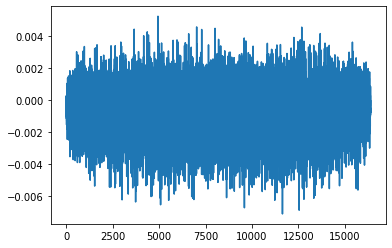

In [8]:
generator = make_generator_model()
#generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
audio = generated_image[0,:,0]
plt.plot(audio)

In [9]:
ipd.Audio(audio, rate=16000)

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv1D(64, 5, 4, padding='same', input_shape=[16384, 1]))
    assert(model.output_shape == (None, 4096, 64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv1D(128, 5, 4, padding='same'))
    assert(model.output_shape == (None, 1024, 128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv1D(256, 5, 4, padding='same'))
    assert(model.output_shape == (None, 256, 256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv1D(512, 5, 4, padding='same'))
    assert(model.output_shape == (None, 64, 512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv1D(1024, 5, 4, padding='same'))
    assert(model.output_shape == (None, 16, 1024))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[5.177646e-05]], shape=(1, 1), dtype=float32)


In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
discriminator_loss(generated_image, generated_image)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3862951>

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = './training_checkpoints_audio_gan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(samples):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_samples = generator(noise, training=True)

      real_output = discriminator(samples, training=True)
      fake_output = discriminator(generated_samples, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for audio_batch in tqdm(dataset):
      train_step(audio_batch)

    # Produce images for the GIF as we go
    ipd.clear_output(wait=True)
    generate_and_save_audio_images(generator,
                                   epoch + 1,
                                   seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  ipd.clear_output(wait=True)
  generate_and_save_audio_images(generator,
                                 epochs,
                                 seed)

In [21]:
def generate_and_save_audio_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(2,2))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.plot(predictions[i, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

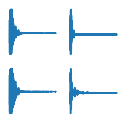

In [22]:
train(train_dataset, EPOCHS)

In [23]:
generator.save('snare_drum_generator.h5')

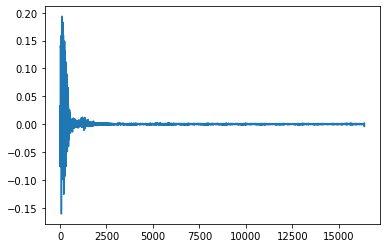

In [46]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
audio = generated_image[0,:,0]
plt.plot(audio)

In [47]:
ipd.Audio(audio, rate=16000)